In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_2019 = 'data/2019.csv'

election_2019 = pd.read_csv(DATA_2019, encoding='utf-8', 
                            names=['community', 'province', 'election_year', 
                                   'party', 'votes', 'percent', 'seats', 'iteration'])

In [3]:
election_2019.head(10)

,community,province,election_year,party,votes,percent,seats,iteration
0,NaN,NaN,2019,Censo,36898883,NaN,NaN,NaN
1,NaN,NaN,2019,Votantes,26478140,71.8,NaN,NaN
2,NaN,NaN,2019,Nulos,276769,NaN,NaN,NaN
3,NaN,NaN,2019,V&aacute;lidos,26201371,NaN,NaN,NaN
4,NaN,NaN,2019,Blancos,199836,NaN,NaN,NaN
5,NaN,NaN,2019,Partido Socialista Obrero Espa&ntilde;ol (PSOE),7513142,28.7,123.0,NaN
6,NaN,NaN,2019,Partido Popular (PP),4373653,16.7,66.0,NaN
7,NaN,NaN,2019,Ciudadanos-Partido de la Ciudadan&iacute;a (C's),4155665,15.9,57.0,NaN
8,NaN,NaN,2019,Unidas Podemos (PODEMOS-IU-EQUO),3751145,14.3,42.0,NaN
9,NaN,NaN,2019,Vox (VOX),2688092,10.3,24.0,NaN


In [4]:
election_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   community      1712 non-null   float64
 1   province       1426 non-null   float64
 2   election_year  1760 non-null   int64  
 3   party          1760 non-null   object 
 4   votes          1760 non-null   int64  
 5   percent        1256 non-null   float64
 6   seats          1130 non-null   float64
 7   iteration      890 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 110.1+ KB


In [5]:
# reformatting spanish chars
accent_map = {'&aacute;': 'á', '&ntilde;': 'ñ', '&iacute;': 'í',
              '&oacute;': 'ó', '&Iacute;': 'Í', '&agrave;': 'à',
              '&Agrave;': 'À', '&Aacute;': 'Á', '&iexcl;': '¡',
              '&uacute;': 'ú', '&Uacute;': 'Ú', '&eacute;': 'é',
              '&Eacute;': 'É'}

party_names_cleaned = list(election_2019.party)
for k in accent_map:
    party_names_cleaned = [re.sub(k, accent_map[k], i) for i in party_names_cleaned]

election_2019['party'] = party_names_cleaned

# Nan values in 'community' col represent totals for entire country - we'll code Spain totals as 0
election_2019['community'] = election_2019.community.fillna(0.0)
election_2019['province'] = election_2019.province.fillna(0.0)

# mapping community codes to community names
comm_dict = {0: 'Spain', 1: 'Andalucía', 2: 'Aragón', 3: 'Asturias',
            4: 'Islas Baleares', 5: 'Islas Canarias', 6: 'Cantabria', 7:'Castilla-La Mancha',
            8: 'Castilla y León', 9: 'Cataluña', 10: 'Extremadura', 11: 'Galicia',
            12: 'Madrid', 13: 'Navarra', 14: 'País Vasco', 15: 'Región de Murcia',
            16: 'La Rioja', 17: 'Comunidad Valenciana', 18: 'Ceuta', 19: 'Melilla'}

election_2019['community_name'] = election_2019['community'].map(comm_dict)

# replace spanish electoral terms for english
elect_terms_english = {'Censo': 'registered',
                      'Votantes': 'voted',
                      'Nulos': 'invalid',
                      'Válidos': 'valid',
                      'Blancos': 'blank'}

for k in elect_terms_english.keys():
    election_2019['party'].replace([k], elect_terms_english[k], inplace=True)

In [6]:
# filling in election month info - two elections were held in 2019 (April and November)
election_2019['iteration'] = election_2019.iteration.fillna('A')

april_index = election_2019[election_2019['iteration']=='A'].index
nov_index = election_2019[election_2019['iteration']=='B'].index

election_2019.loc[april_index, 'election_year'] = 'april-2019'
election_2019.loc[nov_index, 'election_year'] = 'november-2019'

# drop 'iteration' column
election_2019.drop('iteration', axis=1, inplace=True)

# split the two datasets by election

april_2019 = election_2019[election_2019['election_year']=='april-2019'].reset_index(drop=True)
nov_2019 = election_2019[election_2019['election_year']=='november-2019'].reset_index(drop=True)

In [7]:
def get_parties_data(df):
    
    totals_list = ['registered', 'voted', 'invalid', 'blanks', 'valid']
    
    election_totals = df[df['party'].isin(totals_list)].reset_index(drop=True)
    party_totals = df[df['party'].isin(totals_list)==False].reset_index(drop=True)
    
    return election_totals, party_totals

def get_regional_winners(df):
    
    comm_names = list(df.community_name.unique())
    regional_winners = []
    
    for c in comm_names:
        comm_data = df[df.community_name==c]
        party_totals = pd.DataFrame(comm_data.groupby('party')['votes'].sum().sort_values(ascending=False).head(1)).reset_index()
        party_totals['community_name'] = c
        regional_winners.append(party_totals)
        
        #winning_party_name = party_totals.idxmax()
        #winning_party_votes = party_totals.max()
        #regional_winners.append((c, winning_party_name, winning_party_votes))
        
    regional_winners = pd.concat(regional_winners)
    regional_winners.set_index('community_name', drop=True, inplace=True)
    
    return regional_winners

def get_regional_election_totals(df):

    df = df[['community_name', 'party', 'votes']]

    #df = april_2019_totals[['community_name', 'party', 'votes']]
    df = pd.DataFrame(df.groupby(['community_name', 'party'])['votes'].sum())
    df.reset_index(inplace=True)
    df.set_index('community_name', inplace=True)

    col_names = df.party.unique()

    data_to_append = pd.DataFrame()

    for col in col_names:

        data_to_append[col] = df[df.party==col]['votes']

    return data_to_append

In [8]:
# split the dataset by election iteration
april_2019_totals, april_2019_parties = get_parties_data(april_2019)
nov_2019_totals, nov_2019_parties = get_parties_data(nov_2019)

# group by number of votes receievd by each party in each community
apr_parties_counts_2019 = april_2019_parties.groupby('party')['votes'].sum().sort_values(ascending=False)
nov_parties_counts_2019 = nov_2019_parties.groupby('party')['votes'].sum().sort_values(ascending=False)

In [9]:
# grab the winners of each region for each election
april_regional_winners = get_regional_winners(april_2019_parties)
nov_regional_winners = get_regional_winners(nov_2019_parties)

# grab the # of registered voters, voters, valid/invalid ballots, and blanks
april_regional_data = get_regional_election_totals(april_2019_totals)
nov_regional_data = get_regional_election_totals(nov_2019_totals)

## Mapping with GeoPandas

In [10]:
import seaborn as sns
import geopandas as gpd

sns.set_style('white')
sns.set(font_scale=1.5)

ccaa_shpfile = gpd.read_file('data/shapefiles_ccaa_espana.geojson')

names_to_replace = {'Principado de Asturias': 'Asturias',
                    'Comunidad Foral de Navarra': 'Navarra',
                    'Comunidad de Madrid': 'Madrid'}

islas_comm = ['Islas Baleares', 'Islas Canarias']

for k, v in names_to_replace.items():
    ccaa_shpfile['name_1'].replace([k], v, inplace=True)


In [11]:
import matplotlib.patches as mpatches


def combine_dataframes(shpfile, regional_winners, regional_data):
    
    shpfile = pd.concat([shpfile.set_index('name_1'), regional_winners, regional_data], axis=1)
    
    shpfile.drop(['Ceuta', 'Melilla', 'Ceuta y Melilla', 'Spain'], axis=0, inplace=True)
    
    mainland = shpfile[shpfile.index.isin(islas_comm)==False]
    islas = shpfile[shpfile.index.isin(islas_comm)]
    
    return mainland, islas


def create_patches(labels_dict):
    
    patches = []
    for k,v in labels_dict.items():
        patches.append(mpatches.Patch(color=v, label=k))
        
    return patches

def plot_mainland_results(geo_df, cmap, patches):
    
    fig, ax = plt.subplots(figsize=(10,8))

    geo_df.plot(ax=ax,
              color=geo_df.party.apply(lambda x: cmap[x]),
              categorical=True,
              edgecolor='lightgray')

    ax.legend(handles=patches, bbox_to_anchor=(1.5, .3), prop={'size': 12})
    ax.axis('equal')
    ax.set_axis_off()
    
    return ax


In [12]:
april_mainland, april_islas = combine_dataframes(ccaa_shpfile, april_regional_winners, april_regional_data)
nov_mainland, nov_islas = combine_dataframes(ccaa_shpfile, nov_regional_winners, nov_regional_data)

In [13]:
april_mainland = april_mainland.to_crs({'init':'epsg:2062'})
nov_mainland = nov_mainland.to_crs({'init':'epsg:2062'})

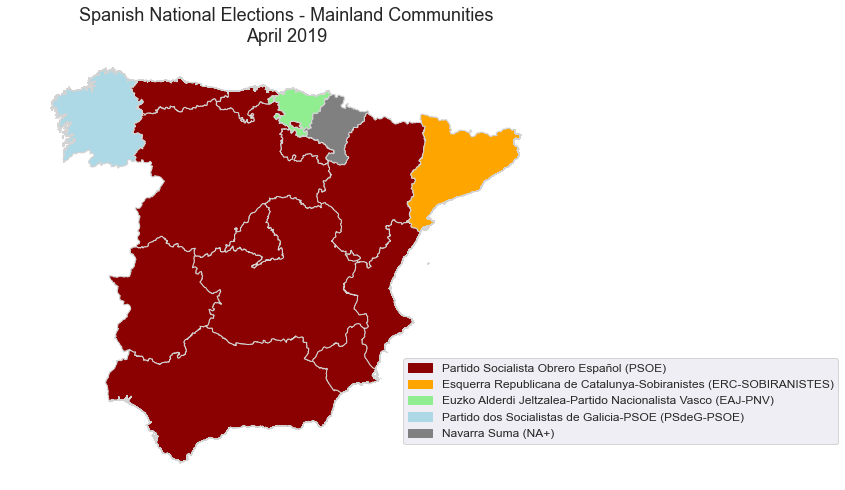

In [16]:
# map labels to color for legend
april_cmap={'Partido Socialista Obrero Español (PSOE)': 'darkred',
       'Esquerra Republicana de Catalunya-Sobiranistes (ERC-SOBIRANISTES)': 'orange',
       'Euzko Alderdi Jeltzalea-Partido Nacionalista Vasco (EAJ-PNV)': 'lightgreen',
       'Partido dos Socialistas de Galicia-PSOE (PSdeG-PSOE)': 'lightblue',
       'Navarra Suma (NA+)': 'gray'}

april_patches = create_patches(april_cmap)

ax = plot_mainland_results(april_mainland, april_cmap, april_patches)

ax.set_title('Spanish National Elections - Mainland Communities\nApril 2019');

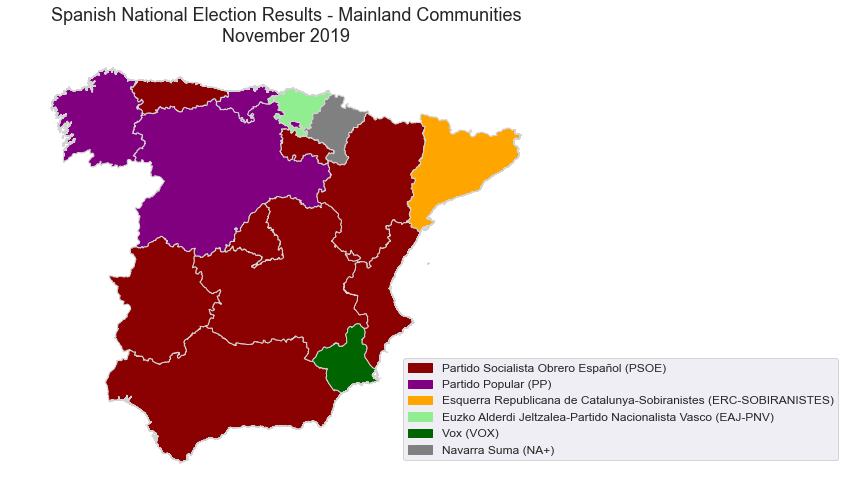

In [18]:
nov_cmap = {'Partido Socialista Obrero Español (PSOE)': 'darkred',
            'Partido Popular (PP)': 'purple',
            'Esquerra Republicana de Catalunya-Sobiranistes (ERC-SOBIRANISTES)': 'orange',
            'Euzko Alderdi Jeltzalea-Partido Nacionalista Vasco (EAJ-PNV)': 'lightgreen',
            'Vox (VOX)': 'darkgreen',
            'Navarra Suma (NA+)': 'gray'}

nov_patches = create_patches(nov_cmap)

ax2 = plot_mainland_results(nov_mainland, nov_cmap, nov_patches)

ax2.set_title('Spanish National Election Results - Mainland Communities\nNovember 2019');